In [1]:
pip install hanlp gensim

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Using cached regex-2024.11.6-cp310-cp310-macosx_10_9_x86_64.whl.metadata (40 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 654.0/654.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 4.5 MB/s eta 0:00:0000:010:01
Using cached regex-2024.11.6-cp310-cp310-macosx_10_9_x86_64.whl (287 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 2.7 MB/s eta 0:00:00a 0:00:01
  Created wheel for hanlp-common: filename=hanlp_common-0.0.23-py3-none-any.whl size=30893 sha256=af795783f87a1bdfe30a4e4390fae4dccdb341462a376de9d1023bfe151f1904
  Stored in directory: /Users/ching-chichou/Library/Caches/pip/wheels/5a/73/1a/972c1db141a01c154ab5d8653971861446650c7634d5d3876e
  Created wheel for hanlp-trie: filename=hanlp_tri

In [7]:
import os
import monpa  # Make sure monpa is installed: pip install monpa
from monpa import utils  # Import the utils for short_sentence



# Helper function to load a stop word list (one stop word per line)
def load_stopwords(filepath):
    stopwords = set()
    with open(filepath, encoding='utf-8') as f:
        for line in f:
            stopwords.add(line.strip())
    return stopwords

# Update path to your stop word list if available
stopwords_path = 'chinese_stopwords.txt'
stopwords = load_stopwords(stopwords_path) if os.path.exists(stopwords_path) else set()

# Preprocess function using monpa.cut and utils.short_sentence for long texts
def preprocess(text):
    # First, split the long text into short sentences using utils.short_sentence,
    # which handles texts over 200 characters by looking for punctuation ("。", "！", "？", "，")
    short_sentences = utils.short_sentence(text)
    
    # Initialize an empty list for tokens
    tokens = []
    
    # Tokenize each short sentence with monpa.cut and extend the tokens list
    for sentence in short_sentences:
        tokens.extend(monpa.cut(sentence))
    
    # Optionally: Filter out stop words and tokens that are too short (e.g., length <= 1)
    filtered_tokens = [token for token in tokens if token not in stopwords and len(token) > 1]
    
    return filtered_tokens

# Define the path to your folder containing .txt files (each document is a novel)
folder_path = './LDA-docs'  # Replace with your actual folder path
documents = []

# Read and preprocess each document in the folder
for filename in os.listdir(folder_path):
    if filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, encoding='utf-8') as file:
            text = file.read()
            tokens = preprocess(text)
            documents.append(tokens)

print(f'Loaded and tokenized {len(documents)} documents.')

Loaded and tokenized 25 documents.


In [24]:
remove_words = ["——", "個子","      我",'      你','      他','      她','        ']
documents = [[token for token in doc if token not in remove_words] for doc in documents]

In [28]:
from gensim import corpora

# Create a dictionary from the list of tokenized documents
dictionary = corpora.Dictionary(documents)
# Optionally filter out tokens that appear in very few or too many documents
dictionary.filter_extremes(no_below=5, no_above=0.5)
# Create the corpus in the bag-of-words format: a list of (token_id, count) pairs per document
corpus = [dictionary.doc2bow(doc) for doc in documents]

print("Size of dictionary:", len(dictionary))
print("Number of documents (corpus size):", len(corpus))

Size of dictionary: 3612
Number of documents (corpus size): 25


In [30]:
from gensim.models.ldamodel import LdaModel

# Specify the number of topics you want to extract
num_topics = 10

# Train the LDA model on the corpus using the dictionary
lda_model = LdaModel(corpus=corpus,
                     num_topics=num_topics,
                     id2word=dictionary,
                     passes=10,        # Increase if needed for better convergence
                     alpha='auto',
                     random_state=42)

# Display the topics with the top 10 keywords in each topic
for idx, topic in lda_model.print_topics(num_words=15):
    print(f"Topic #{idx}: {topic}")

Topic #0: 0.008*"總統" + 0.007*"手臂" + 0.006*"眷村" + 0.006*"球場" + 0.006*"比賽" + 0.005*"爺爺" + 0.005*"快速" + 0.005*"童年" + 0.005*"老爸" + 0.005*"昨晚" + 0.004*"老頭" + 0.003*"故鄉" + 0.003*"傢伙" + 0.003*"第四" + 0.003*"瞬間"
Topic #1: 0.006*"靈魂" + 0.004*"路線" + 0.004*"寶貝" + 0.004*"師父" + 0.004*"一路" + 0.003*"老頭" + 0.003*"老家" + 0.003*"眷村" + 0.003*"來到" + 0.003*"單車" + 0.002*"公車" + 0.002*"村子" + 0.002*"大樓" + 0.002*"書店" + 0.002*"銀行"
Topic #2: 0.004*"同性戀" + 0.003*"眷村" + 0.003*"廣場" + 0.002*"印度" + 0.002*"那邊" + 0.002*"神話" + 0.002*"麻煩" + 0.002*"主義" + 0.002*"同志" + 0.002*"目睹" + 0.002*"自我" + 0.002*"儀式" + 0.002*"村子" + 0.002*"總統" + 0.002*"進來"
Topic #3: 0.013*"眷村" + 0.006*"玫瑰" + 0.006*"歧視" + 0.005*"村子" + 0.005*"童年" + 0.005*"屁股" + 0.005*"空中" + 0.004*"阿姨" + 0.004*"眼光" + 0.004*"性別" + 0.004*"空地" + 0.004*"玩具" + 0.004*"歪歪" + 0.003*"印象" + 0.003*"老家"
Topic #4: 0.009*"咖啡館" + 0.009*"香水" + 0.005*"外公" + 0.004*"旅館" + 0.004*"外婆" + 0.003*"描述" + 0.003*"十六" + 0.003*"創作" + 0.003*"公園" + 0.003*"十七" + 0.002*"寫作" + 0.002*"分子" + 0.002*"原先" + 0.002*"

In [31]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(vis_data)

In [45]:
topic_dict = {}
for i in range(num_topics):
    top_words = lda_model.show_topic(i, topn=15)
    words = ", ".join([word for word, w in top_words])
    topic_dict[f"Topic_{i}"] = words
import pandas as pd
topic_df = pd.DataFrame(list(topic_dict.items()), columns=["Topic", "Top Keywords"])
df_sorted = df.sort_values("Year")
display(df_sorted[["Year", "DocName"] + [f"Topic_{i}" for i in range(num_topics)]])

,Year,DocName,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8,Topic_9
21,1977,擊壤歌-朱天心-1977.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999943
5,1987,张大春-四喜憂國-1987.txt,0.000000,0.000000,0.753913,0.000000,0.000000,0.000000,0.000000,0.000000,0.144649,0.100989
6,1988,肉身菩薩-朱天文-1988.txt,0.000000,0.000000,0.000000,0.000000,0.998508,0.000000,0.000000,0.000000,0.000000,0.000000
20,1988,柴師父-朱天文-1988.txt,0.000000,0.000000,0.999131,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1989,帶我去吧月光-朱天文-1989.txt,0.000000,0.345442,0.396938,0.000000,0.000000,0.000000,0.078289,0.000000,0.083580,0.092354
13,1989,尼羅河女兒-朱天文-1989.txt,0.000000,0.727692,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.069855,0.201987
4,1990,世紀末的華麗-朱天文-1990.txt,0.000000,0.833412,0.166206,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,1990,從前從前有個浦島太郎-朱天心-1990.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999718,0.000000,0.000000,0.000000
11,1990,離開同方-蘇偉貞-1990.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.999972,0.000000
2,1991,蘇偉貞-過站不停-1991.txt,0.000000,0.000000,0.000000,0.000000,0.000000,0.999922,0.000000,0.000000,0.000000,0.000000


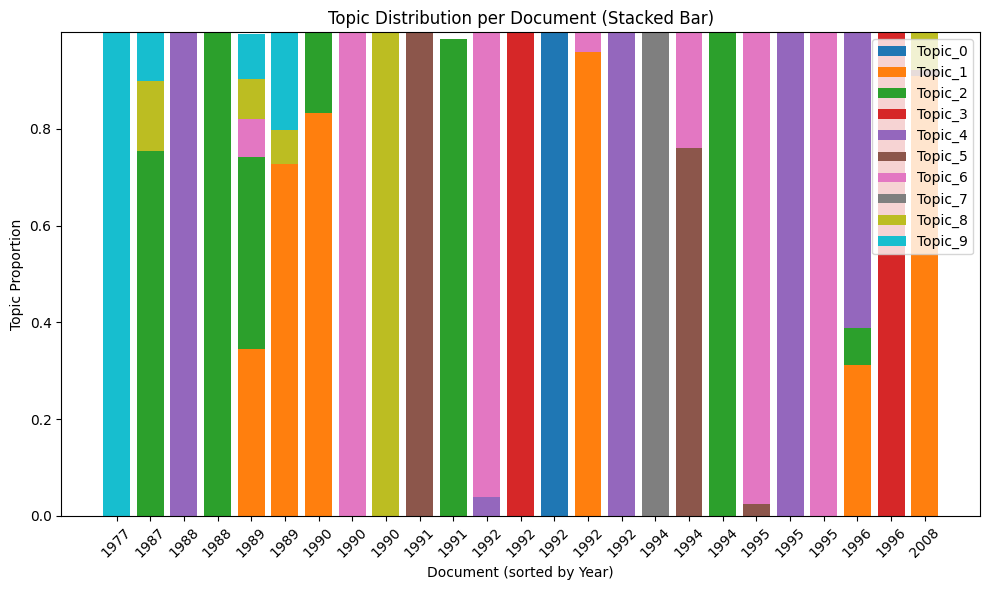

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Sort df by year if you want a chronological x-axis
df_sorted = df.sort_values('Year')

# For stacked bar plotting, get numeric arrays
x = np.arange(len(df_sorted))  # one bar per document
topic_names = [f"Topic_{i}" for i in range(num_topics)]
bottom = np.zeros(len(df_sorted))

plt.figure(figsize=(10, 6))

for topic in topic_names:
    values = df_sorted[topic].values
    plt.bar(x, values, bottom=bottom, label=topic)
    bottom += values  # stack on top

plt.xticks(x, df_sorted['Year'], rotation=45)
plt.xlabel("Document (sorted by Year)")
plt.ylabel("Topic Proportion")
plt.title("Topic Distribution per Document (Stacked Bar)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()